<a href="https://colab.research.google.com/github/pobrien5/JvR-Thesis/blob/main/Field_from_Magnetizied_VdW_Material.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import sympy
import numpy as np
import random
import math
from sympy import Symbol

Calculates the stray field outside a uniformly magnetized thin film with the amperian approach - Replacing the magnetization by an equivalent dirstribution of current density. 

In [2]:
#Constants and experimental parameters

mu_0 = 1.26e-6 # [N/A**2]
mag_vec = np.array([5e-2,0,0]) # [A/m]
fluxon = 2e-15 # [Tm^2]

constant = mu_0 / (4*np.pi)

film_length = 5e-3 # [m] vec: x
film_width = 5e-3 # [m] vec: y
film_thickness = 1e-9 # [m] vec: z

In [3]:
x_limits = [-film_length/2, film_length/2]
y_limits = [-film_width/2, film_width/2]
z_limits = [-film_thickness/2, film_thickness/2]

limits = [x_limits, y_limits, z_limits]
print(limits)

[[-0.0025, 0.0025], [-0.0025, 0.0025], [-5e-10, 5e-10]]


In [4]:
import numpy as np

# Define the vertices of the cuboid
vertices = np.array([
    [-film_length/2, -film_width/2, -film_thickness/2],
    [-film_length/2,  film_width/2, -film_thickness/2],
    [ film_length/2,  film_width/2, -film_thickness/2],
    [ film_length/2, -film_width/2, -film_thickness/2],
    [-film_length/2, -film_width/2,  film_thickness/2],
    [-film_length/2,  film_width/2,  film_thickness/2],
    [ film_length/2,  film_width/2,  film_thickness/2],
    [ film_length/2, -film_width/2,  film_thickness/2]
])

# Define the indices of the faces of the cuboid
faces = np.array([
    [0, 1, 2, 3],
    [0, 1, 5, 4],
    [1, 2, 6, 5],
    [2, 3, 7, 6],
    [3, 0, 4, 7],
    [4, 5, 6, 7]
])

# Calculate the normal vectors of each face
normals = []
for face in faces:
    # Get the vertices of the face
    face_vertices = vertices[face, :]
    #print('Surface Vertices Positions:')
    #print(face_vertices)
    #print('------------------------------')
    
    # Calculate the vectors between the vertices
    vectors = face_vertices[1:, :] - face_vertices[0, :]
    
    # Calculate the normal vector
    normal = np.cross(vectors[0], vectors[1])
    
    # Normalize the normal vector
    normal = normal/np.linalg.norm(normal)
    
    # Check if the normal vector is pointing inwards
    if np.dot(normal, face_vertices[0, :]) > 0:
        normal *= -1
    
    # Add the normal vector to the list
    normals.append(normal)

# Print the normal vectors
#for i, normal in enumerate(normals):
    #print(f"Normal vector of face {i}: {normal}")

In [5]:
import scipy.integrate as spi

def double_integral(integrand, dP_limits, dQ_limits, common_side, dblint_pos_vec):
  dblint_vec = [0, 0, 0]
  tolerance = [1.49e-07, 1.49e-07, 1.49e-04]
  for i in range(3):
    result, _ = spi.dblquad(integrand,
                          dP_limits[0], dP_limits[1],
                            dQ_limits[0], dQ_limits[1],
                             args=(i, common_side, dblint_pos_vec,),
                              epsabs=tolerance[i], epsrel=tolerance[i])
    dblint_vec[i] = result
  return dblint_vec

In [6]:
def double_integral(integrand, dP_limits, dQ_limits, common_side, dblint_pos_vec):
  dblint_vec = [0, 0, 0]
  tolerance = [1.49e-07, 1.49e-07, 1.49e-07]
  result, _ = spi.dblquad(integrand,
                        dP_limits[0], dP_limits[1],
                          dQ_limits[0], dQ_limits[1],
                           args=(2, common_side, dblint_pos_vec,),
                            epsabs=1.49e-02, epsrel=1.49e-02)
  dblint_vec[0] = result
  return dblint_vec

In [7]:
# Find the common element and its index
def common(face_array):
  common_element, idx = next((val, idx) for idx, val in enumerate(face_array[0])
                         if np.any(val == face_array[1]) and np.any(val == face_array[2]) and np.any(val == face_array[3]))
  return common_element, idx

In [8]:
def surface_vec(common, dl_1, dl_2):
  s_vec = [0, 0, 0]
  s_vec[common[1]] = common[0]
  dl_1_index = (1+common[1])%3
  dl_2_index = (2+common[1])%3
  if dl_1_index < dl_2_index: #Makes sure that dl_1 (X) and dl_2 (Y) always appear respectively in this order of integration
    s_vec[dl_1_index] = dl_1
    s_vec[dl_2_index] = dl_2
  else:
    s_vec[dl_1_index] = dl_2
    s_vec[dl_2_index] = dl_1

  return np.array(s_vec)

In [9]:
def surface_integrand(dP, dQ, a, common_side, si_pos_vec): #Might try to remove unneccasry arguments from this function
  si_vec = np.array(surface_vec(common_side, dP, dQ))
  return (np.add(si_pos_vec, -1*si_vec))[a]/(np.linalg.norm(si_pos_vec - si_vec)**3)

In [10]:
r_vec =np.array([0.2e-3,0,100e-9])
result_vec = np.array([0,0,0])

print('r_vec:', r_vec)
print('------------------------------------------')

for face in faces:
    # Get the vertices of the face
    #print(face)
    face_vertices = vertices[face, :]
    
    # Calculate the vectors between the vertices
    vectors = face_vertices[1:, :] - face_vertices[0, :]
    
    # Calculate the normal vector
    normal = np.cross(vectors[0], vectors[1])
    
    # Normalize the normal vector
    normal = normal/np.linalg.norm(normal)
    
    # Check if the normal vector is pointing outwards
    if np.dot(normal, face_vertices[0, :]) < 0:
        normal *= -1
    

    current_vec = np.cross(mag_vec, normal)
    if np.linalg.norm(current_vec) > 0:
      print('common:', common(face_vertices)) #Returns the common x,y,z position (and its index) between all four vertices i.e. The side we are surface integrating over
      print('normal:', normal) 
      print('current vector:', current_vec)
      print('surface vector:', surface_vec(common(face_vertices),Symbol('dP'),Symbol('dQ')))
      common_temp = common(face_vertices)
      indices_ = (2+common_temp[1])%3, (1+common_temp[1])%3
      indices_ = sorted(indices_)
      print('limits', indices_)
      result = double_integral(surface_integrand, limits[indices_[0]], limits[indices_[1]], common_temp, r_vec) 
      #print('1st limits:', limits[indices_[0]])
      #print('2nd limits:', limits[indices_[1]])
      print('integral result:', result)
      result = np.cross(current_vec, result)
      print('cross result:', result)
      #print('surface integrand', surface_integrand(1,1))
      #result = double_integral(surface_integrand, x_limits, y_limits)
      print('------------------------------------------')
      result_vec = np.add(result_vec, result)
    
print('result vec:', result_vec)
      

      #double_integral()
      #np.cross(current_dir, )
    
    # Add the normal vector to the list


r_vec: [2.e-04 0.e+00 1.e-07]
------------------------------------------
common: (-5e-10, 2)
normal: [ 0.  0. -1.]
current vector: [-0.    0.05  0.  ]
surface vector: [dP dQ -5e-10]
limits [0, 1]
integral result: [6.282956574835667, 0, 0]
cross result: [ 0.          0.         -0.31414783]
------------------------------------------
common: (0.0025, 1)
normal: [-0.  1. -0.]
current vector: [-0.    0.    0.05]
surface vector: [dP 0.0025 dQ]
limits [0, 2]
integral result: [1.1259619111070066e-11, 0, 0]
cross result: [ 0.00000000e+00  5.62980956e-13 -0.00000000e+00]
------------------------------------------
common: (-0.0025, 1)
normal: [-0. -1. -0.]
current vector: [ 0.    0.   -0.05]
surface vector: [dP -0.0025 dQ]
limits [0, 2]
integral result: [1.1259619111070066e-11, 0, 0]
cross result: [ 0.00000000e+00 -5.62980956e-13  0.00000000e+00]
------------------------------------------
common: (5e-10, 2)
normal: [-0. -0.  1.]
current vector: [ 0.   -0.05  0.  ]
surface vector: [dP dQ 5e-10]
l

In [11]:
#result vec: [-5.74739175e-08  0.00000000e+00  4.59245489e-13]

In [12]:
def B2(position_vec):
  result_vec = np.array([0,0,0])

  for face in faces:
      face_vertices = vertices[face, :]
      vectors = face_vertices[1:, :] - face_vertices[0, :]
      normal = np.cross(vectors[0], vectors[1])
      normal = normal/np.linalg.norm(normal)
      if np.dot(normal, face_vertices[0, :]) < 0:
          normal *= -1
      
      current_vec = np.cross(mag_vec, normal)
      if np.linalg.norm(current_vec) > 0:
        common_temp = common(face_vertices)
        if common_temp[1] == 1:
          indices_ = (2+common_temp[1])%3, (1+common_temp[1])%3
          indices_ = sorted(indices_)
          #print('limits', indices_)
          result = double_integral(surface_integrand, limits[indices_[0]], limits[indices_[1]], common_temp, position_vec)
          #print('integral result:', result)
          result = np.cross(current_vec, result)
          #print('cross result:', result)
          #print('---------------------------')
          result_vec = np.add(result_vec, result)
          return 2*result_vec
        
      


In [13]:
def B_field(position_vec):
  result_vec = np.array([0,0,0])

  for face in faces:
      # Get the vertices of the face
      #print(face)
      face_vertices = vertices[face, :]
      
      # Calculate the vectors between the vertices
      vectors = face_vertices[1:, :] - face_vertices[0, :]
      
      # Calculate the normal vector
      normal = np.cross(vectors[0], vectors[1])
      
      # Normalize the normal vector
      normal = normal/np.linalg.norm(normal)
      
      # Check if the normal vector is pointing outwards
      if np.dot(normal, face_vertices[0, :]) < 0:
          normal *= -1
      
      current_vec = np.cross(mag_vec, normal)
      if np.linalg.norm(current_vec) > 0:
        #print('common:', common(face_vertices)) #Returns the common x,y,z position (and its index) between all four vertices i.e. The side we are surface integrating over
        #print('normal:', normal) 
        #print('current vector:', current_vec)
        #print('surface vector:', surface_vec(common(face_vertices),Symbol('dP'),Symbol('dQ')))
        common_temp = common(face_vertices)
        indices_ = (2+common_temp[1])%3, (1+common_temp[1])%3
        indices_ = sorted(indices_)
        #print('limits', indices_)
        result = double_integral(surface_integrand, limits[indices_[0]], limits[indices_[1]], common_temp, position_vec)
        #print('integral result:', result)
        result = np.cross(current_vec, result)
        #print('cross result:', result)
        #print('---------------------------')
        result_vec = np.add(result_vec, result)
        
      
  return result_vec

In [14]:
r_vec = np.array([0.2e-3,0,100e-9])

print('r_vec:', r_vec)
print('---------------------------')

print(B_field(r_vec))

print(B2(r_vec))

r_vec: [2.e-04 0.e+00 1.e-07]
---------------------------
[0.00000000e+00 0.00000000e+00 1.13701526e-07]
[0.00000000e+00 1.12596191e-12 0.00000000e+00]


In [ ]:
x_number = int(1e2) # no. of points on graph
x_range = np.linspace(limits[0][0], limits[0][1], num=x_number) # m

B_values = np.zeros((x_number,3))

for i in range(x_number):
  r_vec = np.array([x_range[i], 0, 100e-9])
  B_values[i] = B_field(r_vec)

#plt.plot(x_range, y_prefactor*BX_values,'b')

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity

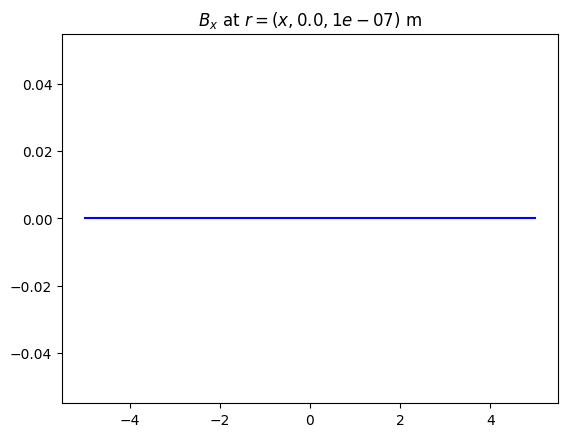

In [ ]:
# r = [x_range, 0, 100e-9]
direction = [Symbol('x'), Symbol('y'), Symbol('z')]

plt.title('$B_{}$ at $r=({}, {}, {})$ m'.format(direction[0], direction[0], r_vec[1], r_vec[2]))
plt.plot(1000*x_range, B_values[:,0], 'b')

1.5697963696517355e-14


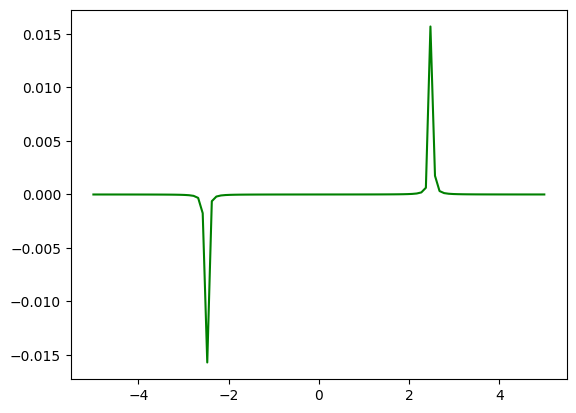

In [ ]:
plt.plot(1000*x_range, 1e12*constant*B_values[:,2], 'g')
print(max(constant*B_values[:,2]))

In [ ]:
print(np.max(B_values[:,0])*constant)

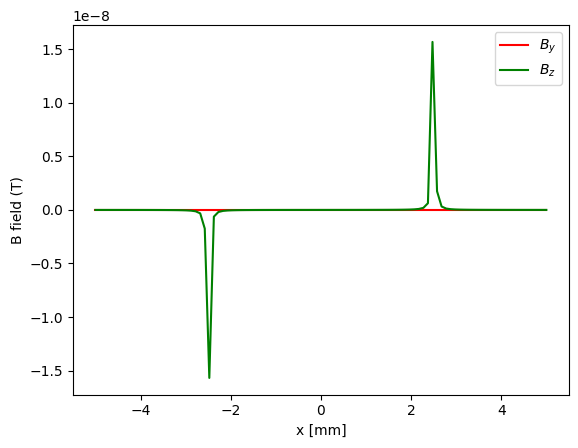

In [ ]:
plt.plot(1000*x_range, B_values[:,0], 'b', label='$B_x$')
plt.plot(1000*x_range, B_values[:,1], 'r', label='$B_y$')
plt.plot(1000*x_range, B_values[:,2], 'g', label='$B_z$')
plt.xlabel("x [mm]")
plt.ylabel("B field (T)")
plt.legend()

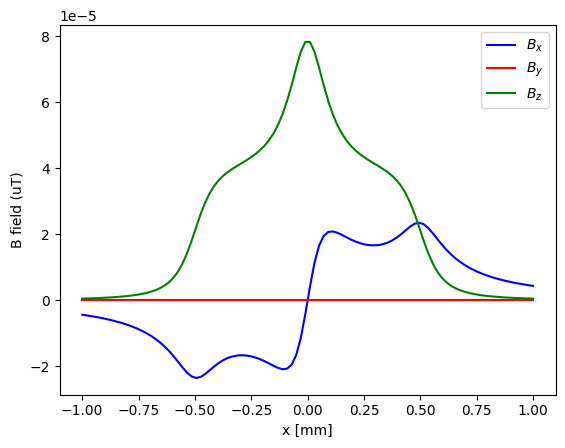

In [ ]:
plt.plot(1000*x_range, 1e6*B_values[:,0]*constant, 'b', label='$B_x$')
plt.plot(1000*x_range, 1e6*B_values[:,1]*constant, 'r', label='$B_y$')
plt.plot(1000*x_range, 1e6*B_values[:,2]*constant, 'g', label='$B_z$')
plt.xlabel("x [mm]")
plt.ylabel("B field (uT)")
plt.legend()